# Inferencia Bayesiana Entrega 2: Matias Moran LU 806/19

## Ejercicio 1

Supongamos que uno tiene una variable aleatoria Y que puede modelar con una distribucion
geométrica. Es decir que $P(Y = y | \theta) = \theta (1—\theta)^{y-1}$ para $y \in \{ 1,2,3,.. \}.$ Se utiliza un prior
$\Beta(a, b)$ para $\theta$.

### A) Qué situacion se representa con una variable aleatoria geométrica?

La variable aleatoria geometrica se usa para representar una distribucion similar a la binomial pero donde queremos saber "Cuantos experimentos de bernoulli con probabilidad p de exito tengo que hacer hasta obtener un exito".

por ejemplo cuantas monedas tengo que tirar hasta sacar cara, cuantos dados tengo que tirar hasta que salga un 3, etc

### B) Derivar la distribucion posterior para $\theta$ suponiendo que se observé $Y = y$. Identificar la distribucion encontrada y sus parametros.

$P(\theta | Y = y) = \frac{P(Y = y| \theta) \cdot L(\theta)}{P(Y = y)}$

$P(\theta | Y = y) = \frac{f(\theta) \cdot f(\theta | Y = y)}{P(Y = y)}$

$P(\theta | Y = y) = \frac{f(\theta) \cdot (1-\theta)^{y-1} \cdot \theta}{P(Y = y)}$

$P(\theta | Y = y) \propto f(\theta) \cdot (1-\theta)^{y-1} \cdot \theta$

Vemos que la forma $(1-\theta)^{y-1} \cdot \theta$ se asemeja mucho a la pdf de la Beta, asi que vamos a probar un prior $\Beta(a,b)$

$P(\theta | Y = y) \propto (1-\theta)^{b-1} \cdot \theta^{a-1} \cdot (1-\theta)^{y-1} \cdot \theta$

$P(\theta | Y = y) \propto (1-\theta)^{b+y-2} \cdot \theta^{a}$

$P(\theta | Y = y) \propto B(a + 1, b + y - 1)$

> **_NOTA:_**
La razon porque la geometrica es tambien una distribucion conjugada de la Beta es porque es un "caso particular" de la distribucion binomial para k=1 (exitos igual a 1) y donde en vez de multiplicarlo por el numero de posibles permutaciones $\binom{n}{1}$ simplemente se omite esta constante porque el exito siempre esta en la ultima posicion y como esto es una constante se va cuando normalizamos la posterior ya que sigue siendo proporcional

### C) El modelo Beta es un prior conjugado de la Geométrica?

Si, vimos que si tenemos un prior beta y nuestra distribucion es geometrica nuestro post tambien es Beta, asi que es un prior conjugado

## Ejericicio 2

Identificar una pregunta que se pueda responder con un modelo de regresion lineal con
$\beta_{0}. \beta_{1} ,\sigma$ como parametros a estimar. Por ejemplo puede ser, altura del hijo en funcion de
altura de la madre, velocidad maxima de un auto en funcion de caballos de fuerza, etc.
Usatus propios datos o simulalos.

$$Y_{i} \sim \mathcal{N}(\mu(x_{i}), \sigma^{2})$$

$$\mu = \beta_{0} + \beta_{1} \cdot x_{i}$$


> **_DATASETS:_**
Los dataset que vamos a utilizar son 3.
- 1 vamos a utilizar la informacion de alquiler de bicicletas en Washinton DC en funcion de la temperatura, este es un ejemplo del capitulo 9 del libro de Bayes rules.
- 2 vamos a utilizar el dataset de Galton que compara las alturas de los padres con los hijos 
- 3 a modo experimental vamos a usar las estadisticas de 1400 jugadores actuales de las ligas europeas de futbol, vamos a tratar de comparar las estadisticas de goles, asistencias y minutos jugados para ver si tienen relacion lineal con el valor de mercado mas alto que tuvo cada jugador, vamos a notar que en este caso las distribuciones no son normales.

### Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import beta
from scipy.optimize import curve_fit
from scipy import integrate
from scipy import special as scipy_special

np.random.seed(42)

In [7]:
#https://www.kaggle.com/datasets/marklvl/bike-sharing-dataset?resource=download
df_bikes = pd.read_csv('../../sandbox/bikes/day.csv')
df_bikes

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,727,2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867,2114
727,728,2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451,3095
728,729,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341
729,730,2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364,1432,1796


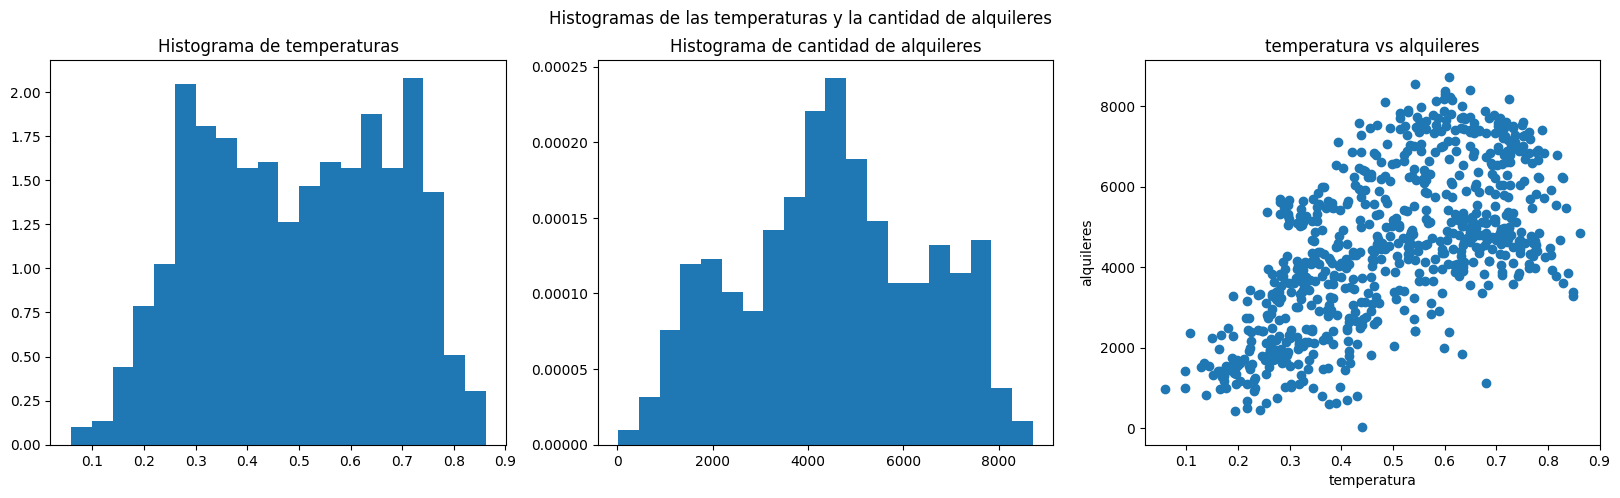

In [49]:
bins_n=20

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Histogramas de las temperaturas y la cantidad de alquileres')

ax[0].plot()
ax[0].set_title('Histograma de temperaturas')
ax[0].hist(df_bikes.temp, bins=bins_n, density=True)

ax[1].plot()
ax[1].set_title('Histograma de cantidad de alquileres')
ax[1].hist(df_bikes.cnt, bins=bins_n, density=True)

ax[2].plot()
ax[2].set_title('temperatura vs alquileres')
ax[2].scatter(df_bikes.temp, df_bikes.cnt)
ax[2].set_xlabel('temperatura')
ax[2].set_ylabel('alquileres')

plt.show()

In [41]:
#https://www.kaggle.com/datasets/jacopoferretti/parents-heights-vs-children-heights-galton-data?select=GaltonFamilies.csv
df_height = pd.read_csv('../../sandbox/parents_children_heights/GaltonFamilies.csv')
df_height

,rownames,family,father,mother,midparentHeight,children,childNum,gender,childHeight
0,1,001,78.5,67.0,75.43,4,1,male,73.2
1,2,001,78.5,67.0,75.43,4,2,female,69.2
2,3,001,78.5,67.0,75.43,4,3,female,69.0
3,4,001,78.5,67.0,75.43,4,4,female,69.0
4,5,002,75.5,66.5,73.66,4,1,male,73.5
...,...,...,...,...,...,...,...,...,...
929,930,203,62.0,66.0,66.64,3,1,male,64.0
930,931,203,62.0,66.0,66.64,3,2,female,62.0
931,932,203,62.0,66.0,66.64,3,3,female,61.0
932,933,204,62.5,63.0,65.27,2,1,male,66.5


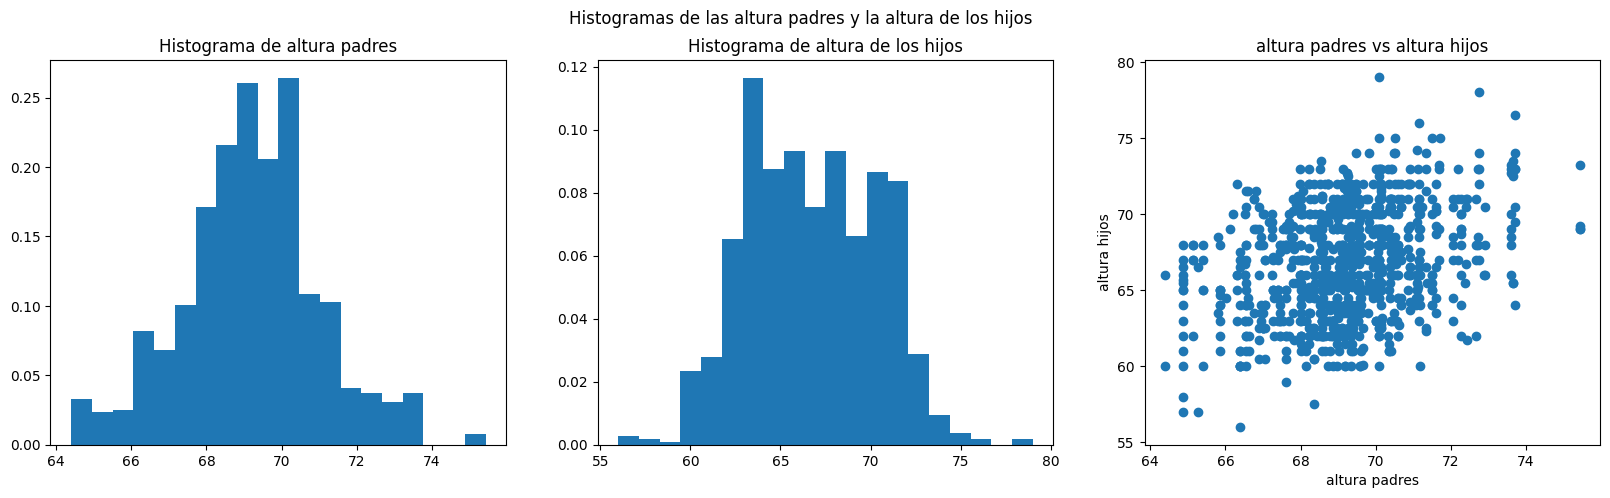

In [50]:
bins_n=20

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Histogramas de las altura padres y la altura de los hijos')

ax[0].plot()
ax[0].set_title('Histograma de altura padres')
ax[0].hist(df_height.midparentHeight, bins=bins_n, density=True,)

ax[1].plot()
ax[1].set_title('Histograma de altura de los hijos')
ax[1].hist(df_height.childHeight, bins=bins_n, density=True)

ax[2].plot()
ax[2].set_title('altura padres vs altura hijos')
ax[2].scatter(df_height.midparentHeight, df_height.childHeight)
ax[2].set_xlabel('altura padres')
ax[2].set_ylabel('altura hijos')

plt.show()

In [13]:
#https://www.kaggle.com/datasets/davidcariboo/player-scores
df_players = pd.read_csv('../../sandbox/football/player_stats/player_stats.csv')
df_players

,Unnamed: 0,player_id,goals,assists,minutes_played,first_name,last_name,name,last_season,current_club_id,...,contract_expiration_date,agent_name,image_url,url,current_club_domestic_competition_id,current_club_name,market_value_in_eur,highest_market_value_in_eur,log_minutes_played,log_highest_value
0,0,3333,38,70,25686,James,Milner,James Milner,2023,1237,...,2025-06-30 00:00:00,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/james-milner/p...,GB1,Brighton & Hove Albion,1000000.0,21000000.0,10.153701,16.860033
1,1,7161,64,78,20209,Jonas,Hofmann,Jonas Hofmann,2023,15,...,2027-06-30 00:00:00,Dr. Marco Gutfleisch,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/jonas-hofmann/...,L1,Bayer 04 Leverkusen,10000000.0,16000000.0,9.913883,16.588099
2,2,16306,42,37,32078,NaN,Casemiro,Casemiro,2023,985,...,2026-06-30 00:00:00,Best of You,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/casemiro/profi...,GB1,Manchester United,20000000.0,80000000.0,10.375926,18.197537
3,3,18644,107,41,20270,Álvaro,Negredo,Álvaro Negredo,2023,2687,...,NaN,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/alvaro-negredo...,ES1,Cádiz CF,300000.0,27000000.0,9.916897,17.111347
4,4,20005,82,89,30184,NaN,Papu Gómez,Papu Gómez,2023,2919,...,NaN,GR Sports,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/papu-gomez/pro...,IT1,AC Monza,2000000.0,18000000.0,10.315067,16.705882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1408,1408,1111663,1,0,34,Kingstone,Mutandwa,Kingstone Mutandwa,2023,1390,...,2027-06-30 00:00:00,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/kingstone-muta...,IT1,Cagliari Calcio,1000000.0,1000000.0,3.526361,13.815511
1409,1409,1184137,0,0,2,Yassin,Tallal,Yassin Tallal,2023,3709,...,2026-06-30 00:00:00,MIV GESTFUT,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/yassin-tallal/...,ES1,Getafe CF,50000.0,50000.0,0.693147,10.819778
1410,1410,1210422,0,0,45,Aboubacar,Bassinga,Aboubacar Bassinga,2023,472,...,NaN,Gesport Espizua SL,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/aboubacar-bass...,ES1,UD Las Palmas,NaN,NaN,3.806662,NaN
1411,1411,1230202,0,0,3,Borja,Vázquez,Borja Vázquez,2023,2687,...,2026-06-30 00:00:00,Gesport Espizua SL,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/borja-vazquez/...,ES1,Cádiz CF,50000.0,50000.0,1.098612,10.819778


In [42]:
df_players = df_players[df_players["minutes_played"] > 500]
df_players = df_players[df_players["goals"].notna()]
df_players = df_players[df_players["assists"].notna()]
df_players = df_players[df_players["log_minutes_played"].notna()]
df_players = df_players[df_players["log_highest_value"].notna()]
df_players = df_players[['goals', 'assists', 'log_minutes_played', 'log_highest_value']]
df_players

,goals,assists,log_minutes_played,log_highest_value
0,38,70,10.153701,16.860033
1,64,78,9.913883,16.588099
2,42,37,10.375926,18.197537
3,107,41,9.916897,17.111347
4,82,89,10.315067,16.705882
...,...,...,...,...
1368,2,0,7.710205,15.201805
1371,5,2,7.821242,16.705882
1373,9,1,7.647786,17.504390
1380,1,0,6.504288,13.122363


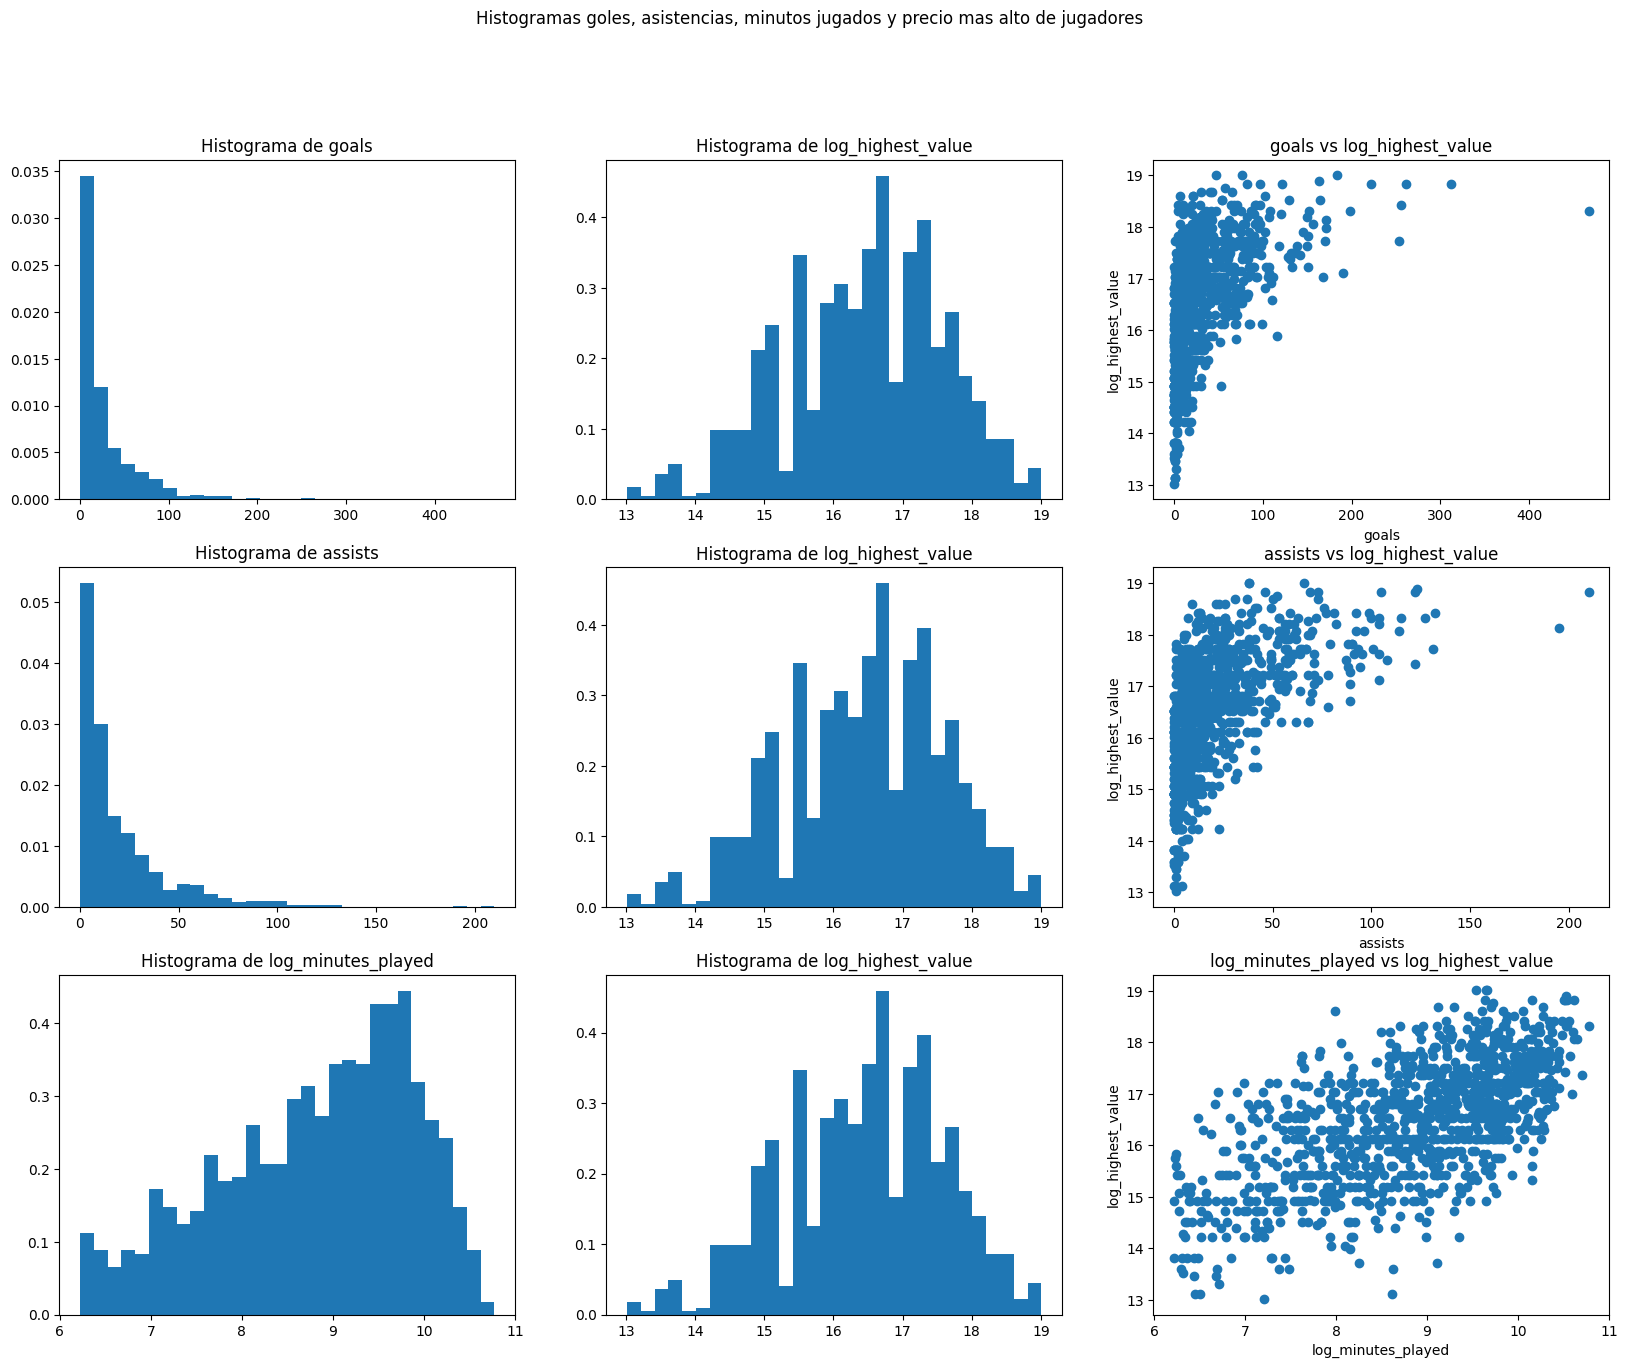

In [53]:
bins_n=30

fig, ax = plt.subplots(3, 3, figsize=(20, 15))
fig.suptitle('Histogramas goles, asistencias, minutos jugados y precio mas alto de jugadores')

for i, col in enumerate(['goals', 'assists', 'log_minutes_played']):
    ax[i,0].plot()
    ax[i,0].set_title(f'Histograma de {col}')
    ax[i,0].hist(df_players[col], bins=bins_n, density=True)

    ax[i,1].plot()
    ax[i,1].set_title('Histograma de log_highest_value')
    ax[i,1].hist(df_players.log_highest_value, bins=bins_n, density=True)

    ax[i,2].plot()
    ax[i,2].set_title(f'{col} vs log_highest_value')
    ax[i,2].scatter(df_players[col], df_players.log_highest_value)
    ax[i,2].set_xlabel(col)
    ax[i,2].set_ylabel('log_highest_value')

plt.show()

- Podemos observar que las variables de goles y asistencias parecen seguir una distribucion exponencial mientras que la variable de minutos jugados parece seguir una distribucion beta o una algo parecido a una normal inclinada mientras que los precios mas altos historicos para cada jugador sigue una normal

### A) Proponer priors para $\beta_{0}. \beta_{1} ,\sigma$

Para el caso de las bicicletas vamos a basarnos en el libro de bayes rules y vamos a hacer la regresion de temperatura vs cantidad de bicicletas alquiladas diarias


b) Escribir la likelihood de los datos de forma analitica en funcién de los pardmetros.

c) Implementar el algoritmo de Metrépolis (MCMC) y generar 5.000 samples del posterior
sin descontar el tramo inicial de la cadena (burn = 0).

4) Graficar la cadena resultante (en 3d para todo el posterior o independientemente para
cada pardmetro en 3 gréficos distintos). ;Parece haber convergido la cadena?

) Repetir el inciso c) y d) para 3 cadenas paralelas. Grafiquelas superpuestas con colores
distintos. ;Cudntos samples tarda en Megar a estado de equilibrio (a ojo)?

£) Elija al azar 100 samples del posterior y grafique las 100 rectas correspondientes su-
perpuestas a los datos.

g) Genere una distribucién posterior predictive para Y con algiin X fijo. Utilicela para
responder alguna pregunta relevante a sus datos.


In [213]:
#Scrapeamos la base de trasnfermarkt para obtener la info
df_europe = pd.read_csv('players_penalties.csv')

print('Number of players in the dataset:', len(df_europe))
df_europe

Number of players in the dataset: 1559


,Name,Goals,Misses
0,ScottTwine,1,1
1,JuniorAjayi,0,0
2,BeñatTurrientes,0,0
3,AndrewMoran,0,1
4,ChrisRamos,0,0
...,...,...,...
1554,Juanmi,0,0
1555,IñigoRuiz de Galarreta,0,0
1556,CédricBakambu,17,1
1557,AbdoulayeDoucouré,1,0


In [214]:
# Para la simplicidad del analisis vamos a filtrar todos los jugadores con menos de 10 penales pateados.
# aunque estaria bueno ver que tanto empeora en el resultado final

df_europe = df_europe[(df_europe["Goals"] + df_europe["Misses"]) > 10]
df_europe['GoalRatio'] = df_europe['Goals'] / (df_europe['Goals'] + df_europe['Misses'])
df_europe

/tmp/ipykernel_1470573/3358776130.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_europe['GoalRatio'] = df_europe['Goals'] / (df_europe['Goals'] + df_europe['Misses'])


,Name,Goals,Misses,GoalRatio
5,ÁlvaroMorata,14,4,0.777778
16,Jordan,10,3,0.769231
17,NikolaVlašić,9,5,0.642857
18,JamesMilner,30,5,0.857143
20,RomanYaremchuk,6,5,0.545455
...,...,...,...,...
1546,NealMaupay,12,3,0.800000
1550,LukeBerry,9,4,0.692308
1551,AntoineGriezmann,24,13,0.648649
1552,HakanÇalhanoğlu,41,4,0.911111


### a) Usando un prior beta de la probabilidad que tiene Montiel de convertir un penal, es decir $\theta \sim \Beta(alpha, beta)$ encontrar la distribución posterior para $\theta$ y graficarla (definir a gusto los parámetros alpha y beta de la distribución).


Para los 2 prior queremos encontrar la distribucion posterior para $\theta$

Primero calculamos la Likehood de ver los datos de montiel asumiendo que cada penal se comporta como un experimento de bernoulli con probabilidad $\theta$, es decir que cada penal tiene la misma probabilidad de terminar en gol y que es independiente del penal anterior (esto es un modelo simplista ya que implica que no depende del arquero, del contexto del partido, de lesiones de jugadores, etc)

- $Y \sim Bin(n, \theta)$
- $\theta \sim  \Beta(\alpha_{0}, \beta_{0})$

- $L(\theta | datosMontiel) = P( Y = k | \theta) = \binom{n}{k}\theta^{k}(1-\theta)^{n-k}=\theta^{12}$
- $Prior(\theta) = \theta^{\alpha_{0} - 1} \cdot (1 - \theta)^{\beta_{0} - 1}$ 



Podemos calcular la *Post* para cada *Prior* como:

- $Post(\theta | datosMontiel) \propto  L(\theta | datosMontiel) \cdot P(\theta)$

- $Post(\theta | datosMontiel) \propto \theta^{12} \cdot \theta^{\alpha_{0} - 1} \cdot (1 - \theta)^{\beta_{0} - 1}$

- $Post(\theta | datosMontiel) \propto \theta^{\alpha_{0} + 11} \cdot (1 - \theta)^{\beta_{0} - 1}$

- $Post(\theta | datosMontiel) \sim Beta(\alpha_{0} + 12, \beta_{0}) $



In [215]:
prior_naive_alpha = 13
prior_naive_beta = 4


In [216]:
# generamos numericamente 10000 samples de la distribucion beta de prior
prior_naive_samples = np.random.beta(prior_naive_alpha, prior_naive_beta, 10000) 
x = np.linspace(0, 1, 30)
y_naive = beta.pdf(x, prior_naive_alpha, prior_naive_beta)

In [217]:
#Estimamos alpha y beta en base a la distribucion de GoalRatio del dataset de jugaradores europeos
def estimate_alpha_beta(x):
    mean_x = np.mean(x)
    var_x = np.var(x)
    alpha_est = mean_x * (mean_x * (1 - mean_x) / var_x - 1)
    beta_est = (1 - mean_x) * (mean_x * (1 - mean_x) / var_x - 1)
    return alpha_est, beta_est

prior_players_alpha, prior_players_beta = estimate_alpha_beta(df_europe['GoalRatio'])

y_players = beta.pdf(x, prior_players_alpha, prior_players_beta)

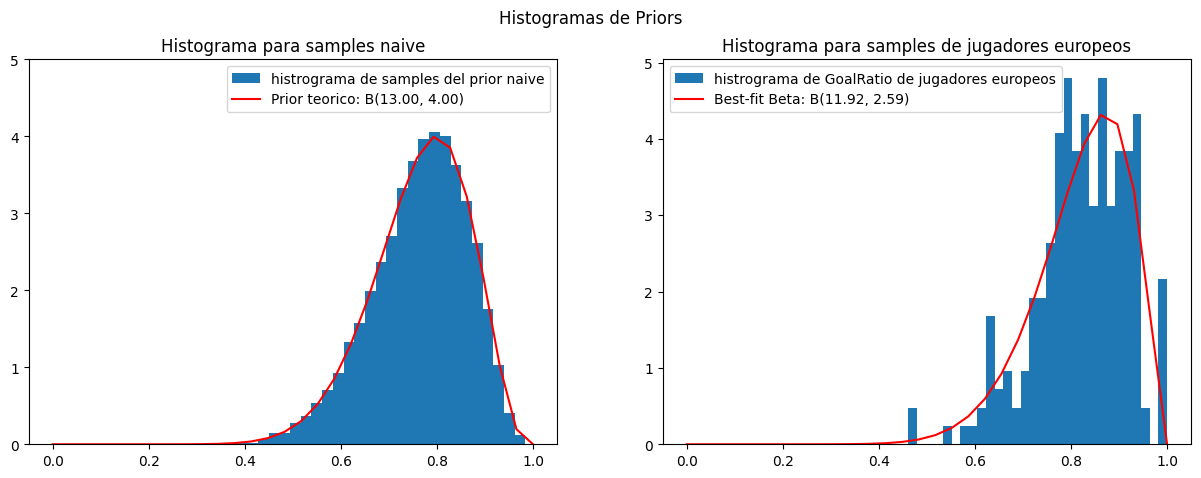

In [218]:
bins_n=30

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Histogramas de Priors')

ax[0].plot()
ax[0].set_title('Histograma para samples naive')
ax[0].hist(prior_naive_samples, bins=bins_n, density=True, label='histrograma de samples del prior naive')
ax[0].plot(x, y_naive, 'r-', label='Prior teorico: B({:.2f}, {:.2f})'.format(prior_naive_alpha, prior_naive_beta))
ax[0].set_xlim(-0.05, 1.05)
ax[0].set_ylim(0, 5)
ax[0].legend()

ax[1].plot()
ax[1].set_title('Histograma para samples de jugadores europeos')
ax[1].hist(df_europe['GoalRatio'], bins=bins_n, density=True, label='histrograma de GoalRatio de jugadores europeos')
ax[1].plot(x, y_players, 'r-', label='Best-fit Beta: B({:.2f}, {:.2f})'.format(prior_players_alpha, prior_players_beta))
ax[1].set_xlim(-0.05, 1.05)
ax[0].set_ylim(0, 5)
ax[1].legend()

plt.show()

In [219]:
y_naive

array([0.00000000e+00, 1.85197664e-14, 6.80162449e-11, 7.88018678e-09,
       2.21157327e-07, 2.84731285e-06, 2.23439486e-05, 1.24338589e-04,
       5.36907090e-04, 1.90616948e-03, 5.78658336e-03, 1.54415591e-02,
       3.69558442e-02, 8.05084724e-02, 1.61425305e-01, 3.00358984e-01,
       5.21712521e-01, 8.49360785e-01, 1.29900113e+00, 1.86725926e+00,
       2.51912018e+00, 3.17733428e+00, 3.71986947e+00, 3.99345867e+00,
       3.85129091e+00, 3.21826268e+00, 2.17372876e+00, 1.01301661e+00,
       1.95910533e-01, 0.00000000e+00])

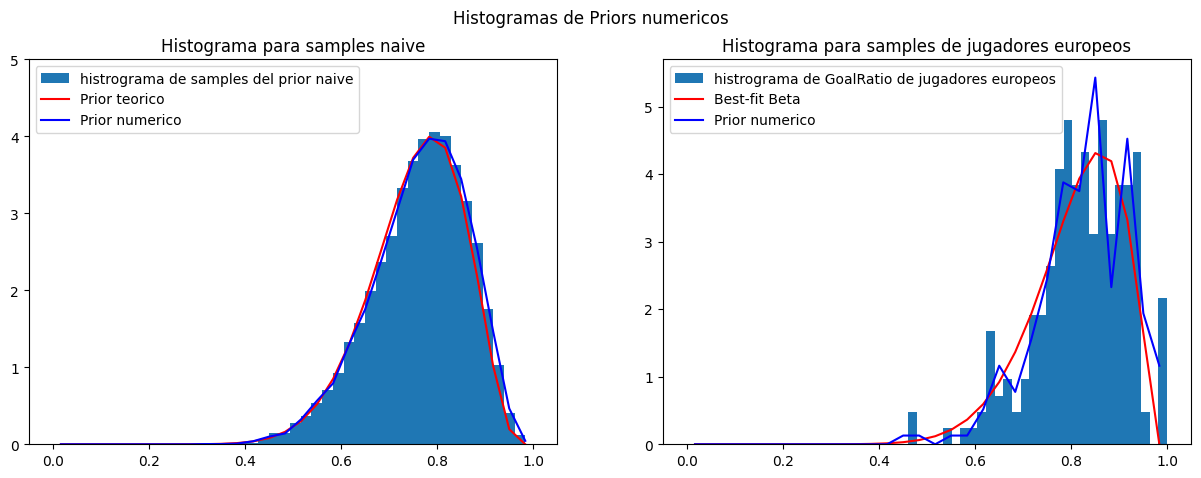

In [220]:
# Ahora vamos a obtener numericamente la funcion del prior a partir del histograma de los samples y la vamos a escalar para que sea una PDF
y_prior_naive, x_bins = np.histogram(prior_naive_samples, bins=bins_n, range=(0, 1))
y_prior_naive = y_prior_naive / np.sum(y_prior_naive * (x_bins[1] - x_bins[0])) # escalamos para que sea PDF dividiendo por la "integral"
x = x_bins[:-1] + (x[1] - x[0]) / 2

y_prior_player, _ = np.histogram(df_europe['GoalRatio'], bins=bins_n, range=(0, 1))
y_prior_players = y_prior_player / np.sum(y_prior_player * (x_bins[1] - x_bins[0]))

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Histogramas de Priors numericos')

ax[0].plot()
ax[0].set_title('Histograma para samples naive')
ax[0].hist(prior_naive_samples, bins=bins_n, density=True, label='histrograma de samples del prior naive')
ax[0].plot(x, y_naive, 'r-', label='Prior teorico')
ax[0].plot(x, y_prior_naive, 'b-', label='Prior numerico')
ax[0].set_xlim(-0.05, 1.05)
ax[0].set_ylim(0, 5)
ax[0].legend()

ax[1].plot()
ax[1].set_title('Histograma para samples de jugadores europeos')
ax[1].hist(df_europe['GoalRatio'], bins=bins_n, density=True, label='histrograma de GoalRatio de jugadores europeos')
ax[1].plot(x, y_players, 'r-', label='Best-fit Beta')
ax[1].plot(x, y_prior_players, 'b-', label='Prior numerico')
ax[1].set_xlim(-0.05, 1.05)
ax[0].set_ylim(0, 5)
ax[1].legend()

plt.show()

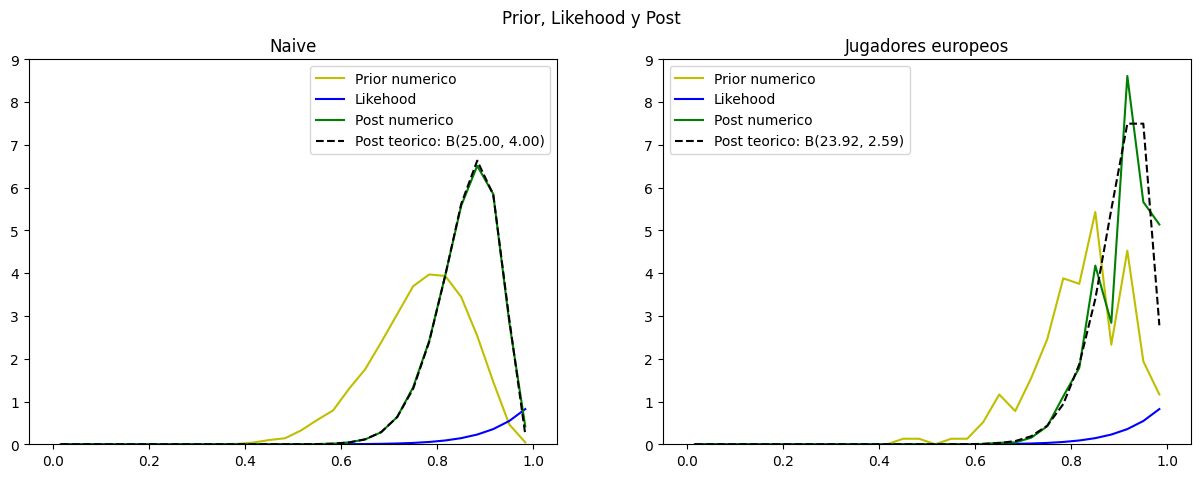

In [221]:
# ahora ya contamos con una discretizacion de la PDF del prior vamos a calcular la Likehood de la binomial y su posterior normalizada

y_likehood = x**12

y_post_naive = y_likehood * y_prior_naive
y_post_naive = y_post_naive / np.sum(y_post_naive * (x[1] - x[0]))

y_post_players = y_likehood * y_prior_players
y_post_players = y_post_players / np.sum(y_post_players * (x[1] - x[0]))


fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Prior, Likehood y Post')

ax[0].set_title('Naive')
ax[0].plot(x, y_prior_naive, 'y-', label='Prior numerico')
ax[0].plot(x, y_likehood, 'b-', label='Likehood')
ax[0].plot(x, y_post_naive, 'g', label='Post numerico')
ax[0].plot(x, beta.pdf(x, prior_naive_alpha + 12, prior_naive_beta), 'black', linestyle='--', label='Post teorico: B({:.2f}, {:.2f})'.format(prior_naive_alpha + 12, prior_naive_beta))
ax[0].set_xlim(-0.05, 1.05)
ax[0].set_ylim(0, 9)
ax[0].legend()

ax[1].set_title('Jugadores europeos')
ax[1].plot(x, y_prior_players, 'y-', label='Prior numerico')
ax[1].plot(x, y_likehood, 'b-', label='Likehood')
ax[1].plot(x, y_post_players, 'g', label='Post numerico')
ax[1].plot(x, beta.pdf(x, prior_players_alpha + 12, prior_players_beta), 'black', linestyle='--', label='Post teorico: B({:.2f}, {:.2f})'.format(prior_players_alpha + 12, prior_players_beta))
ax[1].set_xlim(-0.05, 1.05)
ax[1].set_ylim(0, 9)
ax[1].legend()

plt.show()

### b) ¿Cuál es la probabilidad de que convierta el penal número 13? ¿Cómo se compara con la estimación frecuentista?

In [222]:
from scipy.stats import rv_discrete

# Funcion para generar samples a partir de una distribucion
def sample_from_pdf(n, x_values, y_values):
    pdf = rv_discrete(name='my_pdf', values=(x_values, y_values))
    return pdf.rvs(size=n)

[Naive] Promedio 0.8622987126436783
[Naive] Esperanza Teorica 0.8620689655172413
[Players] Promedio 0.9076337126436783
[Players] Esperanza Teorica 0.90239164871472


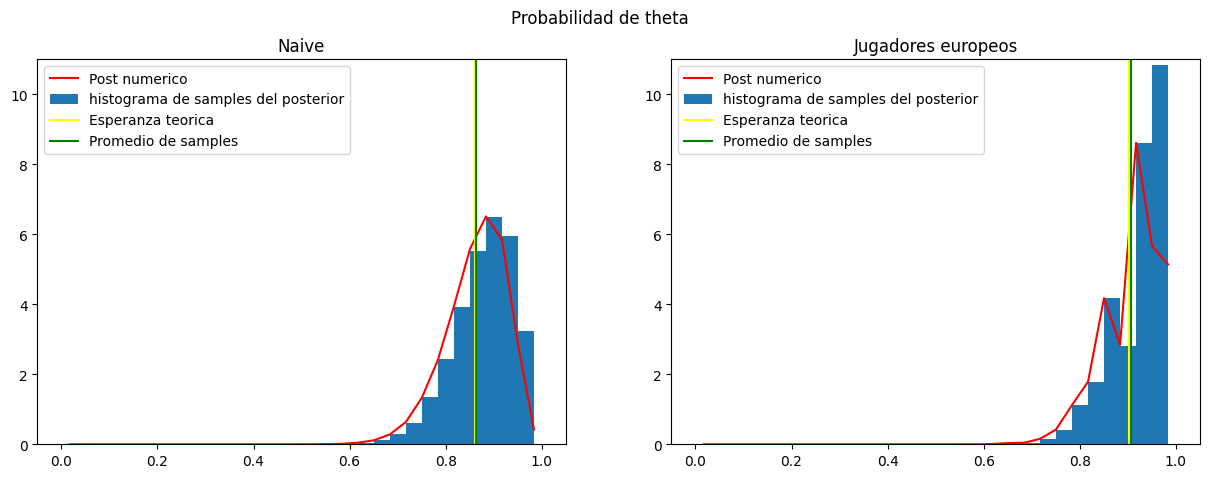

In [223]:
samples_naive = sample_from_pdf(100000, x, y_post_naive/np.sum(y_post_naive)) # normalizamos y_post para que sume 1
samples_players = sample_from_pdf(100000, x, y_post_players/np.sum(y_post_players)) # normalizamos y_post para que sume 1

naive_mean = np.mean(samples_naive)
naive_teorical_mean = (prior_naive_alpha + 12) / (prior_naive_alpha + 12 + prior_naive_beta)

players_mean = np.mean(samples_players)
players_teorical_mean = (prior_players_alpha + 12) / (prior_players_alpha + 12 + prior_players_beta)

print("[Naive] Promedio", naive_mean)
print("[Naive] Esperanza Teorica", naive_teorical_mean)     # E = alpha / alpha + beta 

print("[Players] Promedio", players_mean)
print("[Players] Esperanza Teorica", players_teorical_mean)     # E = alpha / alpha + beta 


fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Probabilidad de theta')

ax[0].set_title('Naive')
ax[0].plot(x, y_post_naive, 'r', label='Post numerico')
ax[0].hist(samples_naive, bins=x, density=True, label='histograma de samples del posterior')
ax[0].axvline(naive_teorical_mean, color ="yellow", label = "Esperanza teorica")
ax[0].axvline(naive_mean, color = "green", linestyle = "-", label = "Promedio de samples")
ax[0].set_xlim(-0.05, 1.05)
ax[0].set_ylim(0, 11)
ax[0].legend()

ax[1].set_title('Jugadores europeos')
ax[1].plot(x, y_post_players, 'r', label='Post numerico')
ax[1].hist(samples_players, bins=x, density=True, label='histograma de samples del posterior')
ax[1].axvline(players_teorical_mean, color ="yellow", label = "Esperanza teorica")
ax[1].axvline(players_mean, color = "green", linestyle = "-", label = "Promedio de samples")
ax[1].set_xlim(-0.05, 1.05)
ax[1].set_ylim(0, 11)
ax[1].legend()

plt.show()

- La probabilidad de que convierta el siguiente penal es de 86.21% que fue lo calculado con las simulaciones para la posterior naive.
- Para la posterior basad en los jugadores europeos aumenta a un 90.68%
- En cambio, si lo hicieramos desde un aproach frecuentista en base a los datos el porcentaje seria 12/12 = 100% de probabilidad de convertir el gol.

### c)  ¿Qué supuestos estamos haciendo sobre el proceso que generó los datos?

- Estamos asumiendo que la probabilidad de convertir penales son independientes entre si al modelarlo como un experimento de Bernoulli
- Estamos asumiendo que la probabilidad de convertir penales es siempre la misma para un jugador y que muchos factores como la habilidad del arquero, el estado fisico del jugador, el contexto del partido no influyen en el resultado

### d)  Haciendo simulaciones, crear un histograma de la distribución predicha de penales convertidos en los próximos 10 penales que ejecute Montiel (posterior predictive distribution).

[Naive] Promedio: 8.6172
[Players] Promedio: 9.07397


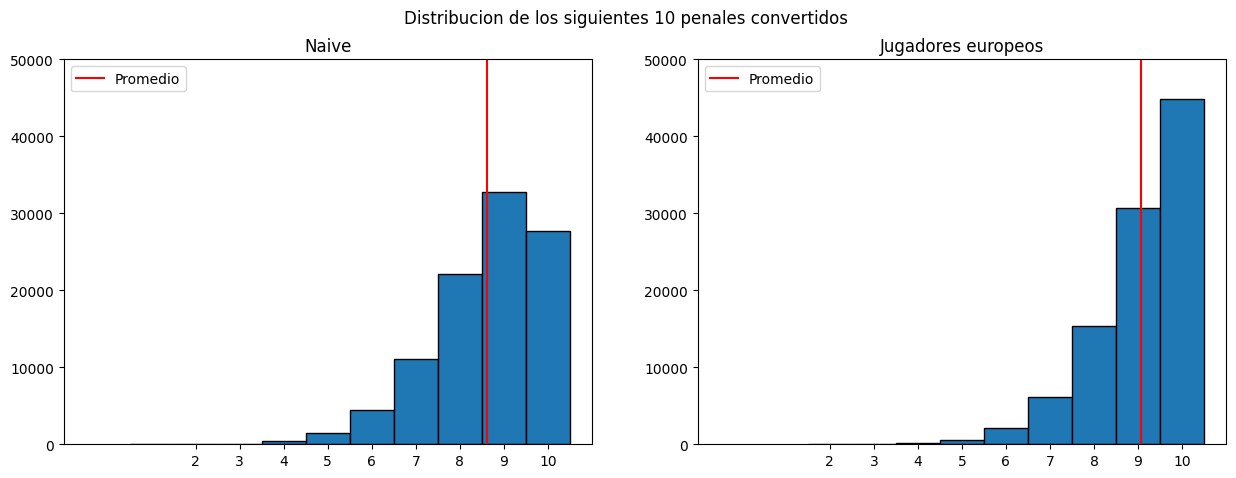

In [224]:
samples_naive = sample_from_pdf(100000, x, y_post_naive/np.sum(y_post_naive)) # normalizamos y_post para que sume 1
samples_players = sample_from_pdf(100000, x, y_post_players/np.sum(y_post_players)) # normalizamos y_post para que sume 1

# Generamos aleatoriamente cuantos goles metió de los 10 tiros para cada sample de theta.
goals_predicted_naive = np.vectorize(lambda x: np.random.binomial(10, x))(samples_naive)
goals_predicted_players = np.vectorize(lambda x: np.random.binomial(10, x))(samples_players)

naive_mean= np.mean(goals_predicted_naive)
print("[Naive] Promedio:", naive_mean)

players_mean= np.mean(goals_predicted_players)
print("[Players] Promedio:", players_mean)



fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Distribucion de los siguientes 10 penales convertidos')

ax[0].set_title('Naive')
d = np.diff(np.unique(goals_predicted_naive)).min()
left_of_first_bin = goals_predicted_naive.min() - float(d)/2
right_of_last_bin = goals_predicted_naive.max() + float(d)/2

ax[0].hist(goals_predicted_naive, np.arange(left_of_first_bin, right_of_last_bin + d, d), edgecolor='black')
ax[0].axvline(naive_mean, color = "red", label = "Promedio")
ax[0].set_ylim(0, 50000)
ax[0].set_xlim(-1, 11)
labels, counts = np.unique(goals_predicted_players, return_counts=True)
ax[0].set_xticks(labels)
ax[0].legend()

ax[1].set_title('Jugadores europeos')
d = np.diff(np.unique(goals_predicted_players)).min()
left_of_first_bin = goals_predicted_players.min() - float(d)/2
right_of_last_bin = goals_predicted_players.max() + float(d)/2

ax[1].hist(goals_predicted_players, np.arange( left_of_first_bin, right_of_last_bin + d, d), edgecolor='black')
ax[1].axvline(players_mean, color = "red", label = "Promedio")
ax[1].set_ylim(0, 50000)
ax[1].set_xlim(-1, 11)
labels, counts = np.unique(goals_predicted_players, return_counts=True)
ax[1].set_xticks(labels)
ax[1].legend()

plt.show()

### e) Estimar la probabilidad de que Montiel meta al menos 8 de los próximos 10 penales que patee.

In [225]:
# contamos la cantidad de samples que tienen al menos 8 goles y dividimos por la cantidad total
print("[Naive] Probabilidad de que meta al menos 8 goles:", len(np.where(goals_predicted_naive >= 8)[0])/len(goals_predicted_naive))
print("[Players] Probabilidad de que meta al menos 8 goles:", len(np.where(goals_predicted_players >= 8)[0])/len(goals_predicted_players))

[Naive] Probabilidad de que meta al menos 8 goles: 0.82588
[Players] Probabilidad de que meta al menos 8 goles: 0.90884
